In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rcParams['figure.dpi'] = 150

import numpy as np
np.set_printoptions(precision=4, suppress=True)

import sys
sys.path.append("..")
from encoder_learning_benchmarks import \
    optimizers, common, datasets, networks, rules, benchmark, \
    utils, animate, positive_definite_matrix

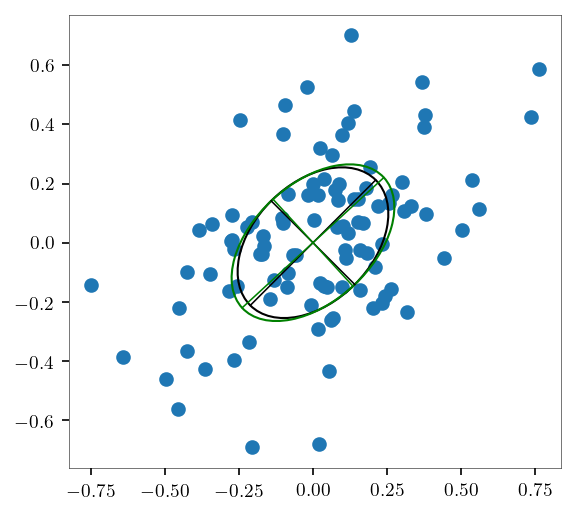

In [3]:
# Generate a random matrix
cov = positive_definite_matrix.PositiveDefiniteMatrix(2).cov_from_givens([0.2, 0.3], [np.pi / 4])[0]
mu = np.zeros((2))

# Sample samples from the covariance matrix and estimate a new matrix
n_smpls = 100
eta = 1e-1
cov_hat = np.zeros((2, 2))
xs = np.random.multivariate_normal(mu, cov, n_smpls)
for i in range(n_smpls):
    f = 1.0 / (i + 1)
    cov_hat = cov_hat * (1.0 - f) +  np.outer(mu - xs[i], mu - xs[i]) * f

fig, ax = plt.subplots()
utils.plot_gaussian(ax, mu=mu, cov=cov, color='k')
utils.plot_gaussian(ax, mu=mu, cov=cov_hat, color='g')
ax.scatter(xs[:, 0], xs[:, 1])
ax.set_aspect(1)

In [9]:
def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigma_center(x):
    return 2.0 / (1.0 + np.exp(-x)) - 1.0
    
def activity_to_scale(x):
    return  np.sin(2.1 * np.pi * (1.0 - np.exp(-5*x)))

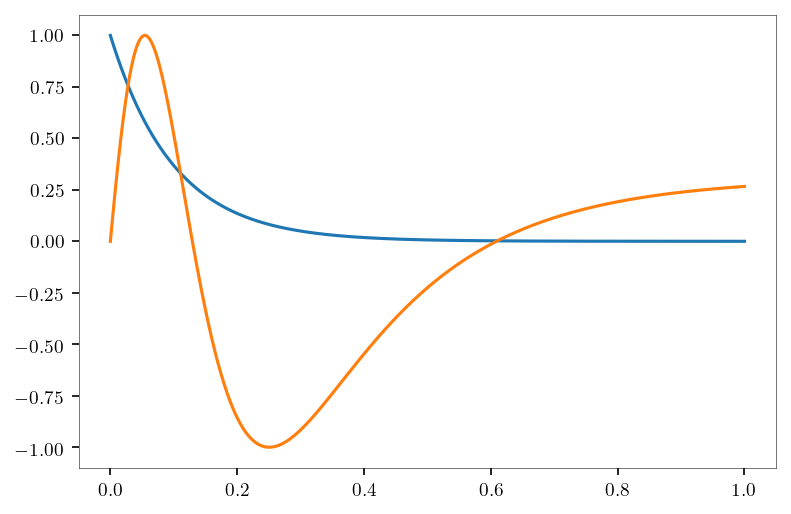

In [10]:
xs = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
ax.plot(xs, np.exp(-10*xs))
ax.plot(xs, np.sin(2.1 * np.pi * (1.0 - np.exp(-5*xs))))

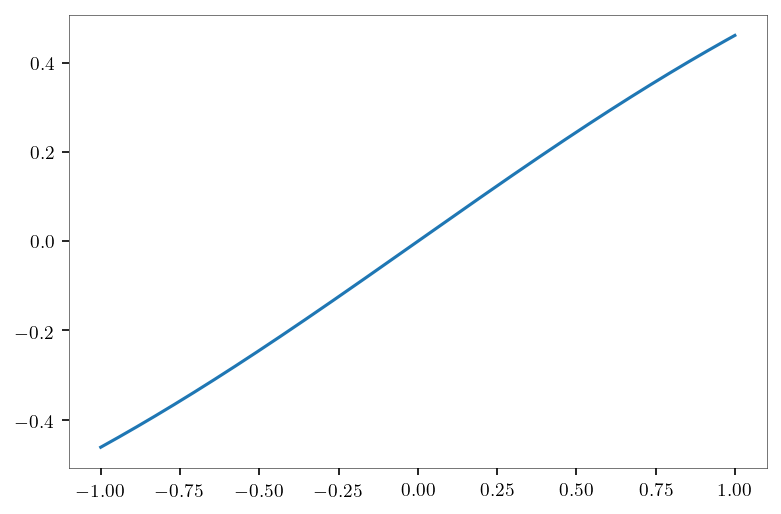

In [12]:
xs = np.linspace(-1.0, 1.0, 1000)
fig, ax = plt.subplots()
ax.plot(xs, sigma_center(xs))

In [146]:
n_smpls = 10000
n_neurons = 10
tau = 500e-3
eta = 1e-1
dt = 1e-3

rng = np.random.RandomState(7889)
dset = datasets.multiplication.Multiplication(biased=False, skewed=True, rng=rng)

I = [0, 1]
mus = np.random.uniform(-1, 1, (n_neurons, 2))
covs = np.zeros((n_neurons, 2, 2))
covs[:, I, I] = 0.1

mus0 = np.copy(mus)
covs0 = np.copy(covs)

xs, ys = dset.sample(n_smpls, 'training')
A_flt = np.zeros(n_neurons)

In [151]:
for i in range(n_smpls):
    # Compute the current activities
    Δ = mus - xs[i][None, :]
    ΣInvs = np.array([np.linalg.inv(Σ) for Σ in covs])
    A = np.exp(-np.einsum('...i,...ij,...j->...', Δ, ΣInvs, Δ))
    dAdxs = 2.0 * np.einsum('...i,...ij', Δ, ΣInvs) * A[:, None]

    # Filter the activities post the softmax
    A_flt += dt * (A - A_flt / tau)

    # Scale the learning rate according to the filtered activity
    η = A * np.array((eta,)) * activity_to_scale(2.0 * (np.max(A) - A))

    # Learn the mean
    mus -= η[:, None] * Δ
    covs += η[:, None, None] * np.einsum('...i,...j->...ij', Δ, Δ)
    covs *= (1.0 + sigma_center(0.1 / n_neurons - A_flt))[:, None, None]

    # Update the mus using an unsupervised learning rule
    #err_mu = np.log(A)
    #net.mus -= η[:, None] * J["mus"][0] * err_mu[:, None]

    #err_theta = np.log(A) - 4.0 #np.array((0.2,)) #A_flt - 0.01 #np.log(A) - 4.0
    #net.thetas -= eta * J["thetas"][0] * err_theta[:, None]

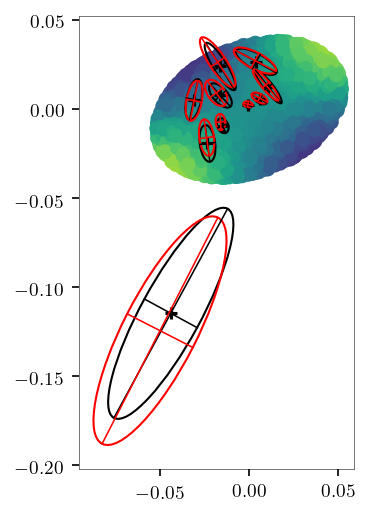

In [152]:
fig, ax = plt.subplots()
ax.scatter(xs[:, 0], xs[:, 1], c=ys[:, 0], vmin=-1.0/np.sqrt(2.0), vmax=1.0/np.sqrt(2))
ax.scatter(mus[:, 0], mus[:, 1], marker='+', color='k')
ax.set_aspect(1)
for i, (mu, cov) in enumerate(zip(mus, covs)):
    utils.plot_gaussian(ax, mu=mu, cov=cov, color='k')
for i, (mu0, cov0) in enumerate(zip(mus0, covs0)):
    utils.plot_gaussian(ax, mu=mu0, cov=cov0, color='r')
mus0, covs0 = np.copy(mus), np.copy(covs)